In [3]:
import torch
import matplotlib.pyplot
import numpy as np

In [2]:
state_dict = torch.load('/home/archy2/luke/Sparsity/weights/rn18_ltr/init_iter_20.pth')

In [19]:
for k, v in state_dict.items(): 
    if 'weight_mask' in k:
        print(f'{k} of shape: {v.size()}')
        print(f'Sparsity: {torch.sum(v == 0).float() / v.numel()}')
        num_kernel_weights = torch.sum(v, (-2,-1))
        print(f'0: {torch.sum(num_kernel_weights == 0).item()}')
        print(f'1: {torch.sum(num_kernel_weights == 1).item()}')
        print(f'2: {torch.sum(num_kernel_weights == 2).item()}')
        print(f'3: {torch.sum(num_kernel_weights == 3).item()}')
        print(f'4: {torch.sum(num_kernel_weights == 4).item()}')
        print(f'5: {torch.sum(num_kernel_weights == 5).item()}')
        print(f'6: {torch.sum(num_kernel_weights == 6).item()}')
        print(f'7: {torch.sum(num_kernel_weights == 7).item()}')
        print(f'8: {torch.sum(num_kernel_weights == 8).item()}')
        print(f'9: {torch.sum(num_kernel_weights == 9).item()}')
        print(f'Total Kernels: {num_kernel_weights.numel()}')
        print()



conv1.weight_mask of shape: torch.Size([64, 3, 3, 3])
Sparsity: 0.2083333283662796
0: 0
1: 0
2: 0
3: 1
4: 4
5: 12
6: 46
7: 50
8: 48
9: 31
Total Kernels: 192

layer1.0.conv1.weight_mask of shape: torch.Size([64, 64, 3, 3])
Sparsity: 0.8874240517616272
0: 1504
1: 1490
2: 756
3: 257
4: 74
5: 9
6: 6
7: 0
8: 0
9: 0
Total Kernels: 4096

layer1.0.conv2.weight_mask of shape: torch.Size([64, 64, 3, 3])
Sparsity: 0.9091254472732544
0: 1798
1: 1492
2: 605
3: 165
4: 27
5: 9
6: 0
7: 0
8: 0
9: 0
Total Kernels: 4096

layer1.1.conv1.weight_mask of shape: torch.Size([64, 64, 3, 3])
Sparsity: 0.9047037959098816
0: 1825
1: 1386
2: 630
3: 177
4: 60
5: 14
6: 3
7: 0
8: 1
9: 0
Total Kernels: 4096

layer1.1.conv2.weight_mask of shape: torch.Size([64, 64, 3, 3])
Sparsity: 0.916124165058136
0: 2127
1: 1212
2: 492
3: 193
4: 50
5: 18
6: 1
7: 3
8: 0
9: 0
Total Kernels: 4096

layer2.0.conv1.weight_mask of shape: torch.Size([128, 64, 3, 3])
Sparsity: 0.9223904013633728
0: 4425
1: 2353
2: 1002
3: 306
4: 84
5: 21
6: 1

In [ ]:
class StructuredPruning(prune.BasePruningMethod):
    """Prune the rows of the weights."""
    PRUNING_TYPE = 'structured'

    def compute_mask(self, t, default_mask):
        mask = default_mask.clone()
        torch.sum(torch.abs(t), dim=0)
        mask.view(-1)[::2] = 0
        return mask

In [65]:
def compute_mask(t, default_mask, amount=.1):
        mask = default_mask.clone()

        #incorporate sparsity to account for already zero-ed rows.
        sparsity = torch.sum((torch.sum(torch.abs(mask), dim=0)==0)) / mask.size(0)
        amount +=  sparsity

        #Prune (sparsity+amount)% neurons! Always at least prune 1 new neuron every time.
        num_neurons_to_prune = max(1+int(sparsity*mask.size(0)), torch.sum(mask==1)*amount // mask.size(0))

        #If you sparsity mask is already 0, then do nothing.
        if num_neurons_to_prune > mask.size(1):
                return mask

        #Get the indices of the lowest magnitude neurons
        values, indices = torch.topk(torch.sum(torch.abs(t), dim=0), k=max(1+int(sparsity*mask.size(0)), torch.sum(mask==1)*amount // mask.size(0)), largest=False)

        #Prune these neurons
        mask[:, indices] = 0
        return mask

t = torch.randn((4,5))
mask = torch.ones((4,5))

In [72]:
print(mask)
mask = compute_mask(t, mask)
print(mask)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
tensor([0., 0., 0., 0., 0.])
tensor(1.2500)
tensor(1.3500)
tensor([[ 0.2982, -0.6009, -0.5124,  1.0658,  0.7568],
        [-0.2014,  0.9619, -0.6086,  0.0802, -1.3503],
        [ 0.2050, -1.2293, -0.7063, -1.4735, -0.4453],
        [-1.2086,  0.4892,  1.0581, -1.2028,  0.0739]])
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


In [14]:
amount = .2
print(torch.sum(mask==1)*amount // mask.size(0))
#int(amount*torch.sum(mask==1) size(1)

tensor(1.)


# Diagonals

In [ ]:
def extract_diagonals(tensor):
    n = tensor.size(0)
    result = torch.zeros((n, n), dtype=tensor.dtype)

    for i in range(n):
        result[i] = torch.diagonal(tensor, offset=i)
    for i in range(1, n):
        result[i + n - 1] = torch.diagonal(tensor, offset=-i)

    return result

In [80]:
import torch

def extract_diagonals_from_large_matrix(tensor):
    n, m = tensor.shape
    k = m // n
    result = torch.zeros((n * k, n), dtype=tensor.dtype)

    for sub_matrix_index in range(k):
        sub_matrix = tensor[:, sub_matrix_index * n : (sub_matrix_index + 1) * n]
        for i in range(n):
            diag = torch.diagonal(sub_matrix, offset=i)
            result[sub_matrix_index * n + i, :len(diag)] = diag
        for i in range(1, n):
            diag = torch.diagonal(sub_matrix, offset=-i)
            result[sub_matrix_index * n + (n-1) + i, :len(diag)] = diag

    return result

# Example usage:
tensor = torch.tensor([[0, 1, 2, 3, 4, 5],
                       [6, 7, 8, 9, 10, 11],
                       [12, 13, 14, 15, 16, 17]])

result = extract_diagonals_from_large_matrix(tensor)
print(result)


IndexError: index 6 is out of bounds for dimension 0 with size 6

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [44]:
def plot_iter(x, name):
    plt.plot(np.arange(len(x)), x, label=name)

def plot_params(x, name, total_params=1316864):
    plt.plot([(1-.8**i)*total_params for i in np.arange(len(x))], x, label=name)

def plot_sparsity(x, name):
    plt.plot([(1-.8**i) for i in np.arange(len(x))], x, label=name)
    
rn18_delta = torch.load('weights/rn18_delta/accuracies.pt')
rn18_ltr = torch.load('weights/rn18_ltr/accuracies.pt')
mlp_delta = torch.load('weights/mlp_delta/accuracies.pt')
mlp_ltr = torch.load('weights/mlp_ltr/accuracies.pt')
mlp_lrr = torch.load('weights/mlp_lrr/accuracies.pt')

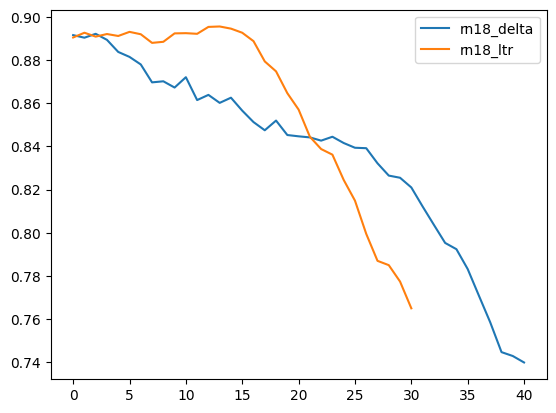

In [37]:
plot(rn18_delta, 'rn18_delta')
plot(rn18_ltr, 'rn18_ltr')

plt.legend()
plt.show()

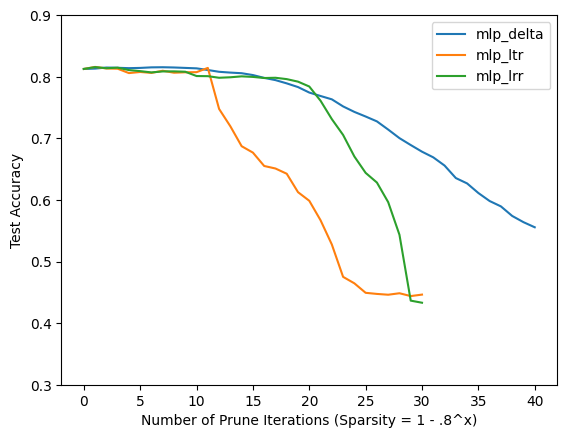

In [46]:
plot(mlp_delta, 'mlp_delta')
plot(mlp_ltr, 'mlp_ltr')
plot(mlp_lrr, 'mlp_lrr')

plt.ylim(.3,.9)
plt.ylabel('Test Accuracy')
plt.xlabel('Number of Prune Iterations (Sparsity = 1 - .8^x)')
plt.legend()
plt.show()

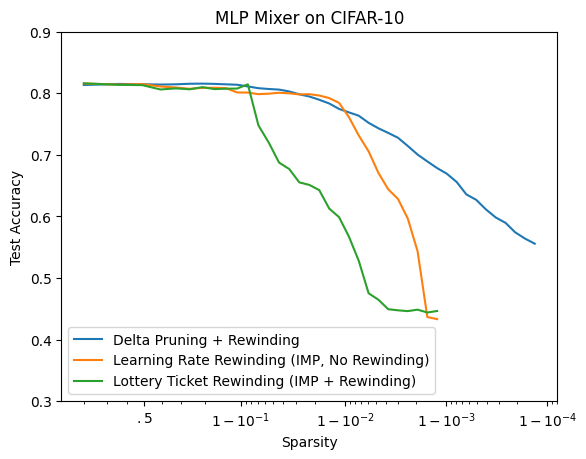

In [47]:
plot_sparsity(mlp_delta, 'Delta Pruning + Rewinding')
plot_sparsity(mlp_lrr, 'Learning Rate Rewinding (IMP, No Rewinding)')
plot_sparsity(mlp_ltr, 'Lottery Ticket Rewinding (IMP + Rewinding)')

plt.ylim(.3,.9)
plt.title('MLP Mixer on CIFAR-10')
plt.ylabel('Test Accuracy')
plt.xlabel('Sparsity')
plt.xscale('logit',one_half='.5') #linear', 'log', 'symlog', 'asinh', 'logit', 'function', 'functionlog'
plt.legend()
plt.show()